In [1]:
import pandas as pd

In [2]:
semi_training_df = pd.read_pickle('semi_super_training_data_with_use_vectors_80.zip', compression='zip')

In [3]:
labeled_test_df = pd.read_pickle('training_data_with_use_vectors.zip', compression='zip')
print(len(labeled_test_df))

1571


In [4]:
from sklearn.model_selection import train_test_split
#Split the fuzzy matched records to be mixed in with training, the other half exclusively for testin
train_labeled, test_labeled = train_test_split(labeled_test_df, test_size=0.5)

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing
import tensorflow as tf

In [6]:
#Get the labels
training_labels = np.asarray(semi_training_df['issueArea'].to_list() + train_labeled['issueArea'].to_list())
print(len(training_labels))
print(training_labels.shape)

4600
(4600,)


In [7]:
#Document Sentences
MAX_LEN = 300
EMBEDDING_SIZE = 512  
def generate_sequences(vectors_list):
    sequence_vectors = []
    for embedding_array in vectors_list:
        diff_pad = np.max(MAX_LEN - len(embedding_array), 0)
        if diff_pad > 0:
            zeros_pad = np.array(np.zeros((diff_pad, EMBEDDING_SIZE)))
            appended = np.append(embedding_array, zeros_pad)
            resized = np.resize(appended, (MAX_LEN, EMBEDDING_SIZE))
            sequence_vectors.append(resized)
        else:
            trimmed = embedding_array[MAX_LEN:]
            resized = np.resize(trimmed, (MAX_LEN, EMBEDDING_SIZE))
            sequence_vectors.append(resized)
    return np.array(sequence_vectors)     

def merge(document_list, sentence_list): 
    return [[document_vector] + sentence_vectors for (document_vector, sentence_vectors) in zip(document_list, sentence_list)]

document_list = semi_training_df['use_vector_document'].tolist() + train_labeled['use_vector_document'].to_list() 
sentences_list = semi_training_df['use_vectors_sentences'].tolist() + train_labeled['use_vectors_sentences'].to_list() 
merged_list = merge(document_list, sentences_list)
training_sequences = generate_sequences(merged_list)
print(training_sequences.shape) 

#MemoryError: Unable to allocate 52.7 GiB for an array with shape (4601, 3000, 512) and data type float64

(4600, 300, 512)


In [8]:
# def merge(lst1, lst2): 
#     return [[a] + b for (a, b) in zip(lst1, lst2)]
# lst1 = [[1,2],[5,6]]
# lst2 = [[[3,4],[3,4]],[[7,8],[7,8]]]
# print(merge(lst1, lst2))

In [9]:
#Get features and labels for the test set
test_document_list = test_labeled['use_vector_document'].tolist() 
test_sentences= test_labeled['use_vectors_sentences'].to_list()
test_merged_list = merge(test_document_list, test_sentences)
test_sequences = generate_sequences(test_merged_list)
print(test_sequences.shape) 
test_labels=test_labeled['issueArea'].tolist()


(786, 300, 512)


In [10]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(training_labels)

def encode(label_encoder, labels):
    enc = label_encoder.transform(labels)
    return tf.keras.utils.to_categorical(enc)

def decode(label_encoder, one_hot):
    dec = np.argmax(one_hot, axis=1)
    return label_encoder.inverse_transform(dec)

In [11]:
test = encode(label_encoder, [1, 2, 7, 12,13])
print(test)
untest = decode(label_encoder, test)
print(untest)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[ 1.  2.  7. 12. 13.]


In [12]:
#Simple connected layers
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.models import Model

inputs = Input(name='inputs',shape=[MAX_LEN, 512])
dropout = Dropout(0.2)(inputs)
lstm= Bidirectional(LSTM(512))(dropout)
dense1 = Dense(1024, activation='relu')(lstm)
dropout1 = Dropout(0.2)(dense1)
# dense2 = Dense(512, activation='relu')(dropout1)
# dropout2 = Dropout(0.2)(dense2)
pred = Dense(13, activation='softmax')(dropout1)
model = Model(inputs=inputs, outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 300, 512)]        0         
_________________________________________________________________
dropout (Dropout)            (None, 300, 512)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 1024)              4198400   
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 13)                13325     
Total params: 5,261,325
Trainable params: 5,261,325
Non-trainable params: 0
___________________________________________________

In [13]:
encoded_training_labels = encode(label_encoder,training_labels)
print(len(encoded_training_labels))
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=90)
mc = ModelCheckpoint('best_model_tf_model_bidirectional.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = model.fit(training_sequences,encoded_training_labels , epochs=150, batch_size=5, validation_split=0.2, callbacks=[mc])

4600
Train on 3680 samples, validate on 920 samples
Epoch 1/150
3675/3680 [============================>.] - ETA: 0s - loss: 1.4989 - accuracy: 0.5404
Epoch 00001: val_accuracy improved from -inf to 0.63587, saving model to best_model_tf_model_bidirectional.h5
3680/3680 [==============================] - 161s 44ms/sample - loss: 1.4980 - accuracy: 0.5405 - val_loss: 1.1405 - val_accuracy: 0.6359
Epoch 2/150
3675/3680 [============================>.] - ETA: 0s - loss: 1.1459 - accuracy: 0.6239
Epoch 00002: val_accuracy improved from 0.63587 to 0.66413, saving model to best_model_tf_model_bidirectional.h5
3680/3680 [==============================] - 160s 43ms/sample - loss: 1.1457 - accuracy: 0.6242 - val_loss: 1.0257 - val_accuracy: 0.6641
Epoch 3/150
3675/3680 [============================>.] - ETA: 0s - loss: 1.0281 - accuracy: 0.6482
Epoch 00003: val_accuracy improved from 0.66413 to 0.69239, saving model to best_model_tf_model_bidirectional.h5
3680/3680 [============================

3675/3680 [============================>.] - ETA: 0s - loss: 0.1535 - accuracy: 0.9448
Epoch 00027: val_accuracy improved from 0.75109 to 0.75761, saving model to best_model_tf_model_bidirectional.h5
3680/3680 [==============================] - 163s 44ms/sample - loss: 0.1545 - accuracy: 0.9443 - val_loss: 1.3492 - val_accuracy: 0.7576
Epoch 28/150
3675/3680 [============================>.] - ETA: 0s - loss: 0.1378 - accuracy: 0.9483
Epoch 00028: val_accuracy did not improve from 0.75761
3680/3680 [==============================] - 162s 44ms/sample - loss: 0.1376 - accuracy: 0.9484 - val_loss: 1.5739 - val_accuracy: 0.7141
Epoch 29/150
3675/3680 [============================>.] - ETA: 0s - loss: 0.1266 - accuracy: 0.9562
Epoch 00029: val_accuracy did not improve from 0.75761
3680/3680 [==============================] - 162s 44ms/sample - loss: 0.1265 - accuracy: 0.9563 - val_loss: 1.4726 - val_accuracy: 0.7435
Epoch 30/150
3675/3680 [============================>.] - ETA: 0s - loss: 0.

3680/3680 [==============================] - 162s 44ms/sample - loss: 0.0678 - accuracy: 0.9837 - val_loss: 1.8496 - val_accuracy: 0.7630
Epoch 55/150
3675/3680 [============================>.] - ETA: 0s - loss: 0.0291 - accuracy: 0.9927
Epoch 00055: val_accuracy did not improve from 0.76304
3680/3680 [==============================] - 162s 44ms/sample - loss: 0.0290 - accuracy: 0.9927 - val_loss: 2.2086 - val_accuracy: 0.7467
Epoch 56/150
3675/3680 [============================>.] - ETA: 0s - loss: 0.0676 - accuracy: 0.9801
Epoch 00056: val_accuracy did not improve from 0.76304
3680/3680 [==============================] - 163s 44ms/sample - loss: 0.0676 - accuracy: 0.9802 - val_loss: 2.0177 - val_accuracy: 0.7467
Epoch 57/150
3675/3680 [============================>.] - ETA: 0s - loss: 0.0292 - accuracy: 0.9918
Epoch 00057: val_accuracy did not improve from 0.76304
3680/3680 [==============================] - 162s 44ms/sample - loss: 0.0292 - accuracy: 0.9918 - val_loss: 2.4566 - val_

Epoch 83/150
3675/3680 [============================>.] - ETA: 0s - loss: 0.0198 - accuracy: 0.9935 ETA: 0s - loss: 0.0198 - accuracy: 0.99
Epoch 00083: val_accuracy did not improve from 0.76304
3680/3680 [==============================] - 162s 44ms/sample - loss: 0.0198 - accuracy: 0.9935 - val_loss: 2.1373 - val_accuracy: 0.7489
Epoch 84/150
3675/3680 [============================>.] - ETA: 0s - loss: 0.0648 - accuracy: 0.9853
Epoch 00084: val_accuracy did not improve from 0.76304
3680/3680 [==============================] - 162s 44ms/sample - loss: 0.0647 - accuracy: 0.9853 - val_loss: 2.2204 - val_accuracy: 0.7413
Epoch 85/150
3675/3680 [============================>.] - ETA: 0s - loss: 0.0277 - accuracy: 0.9943
Epoch 00085: val_accuracy did not improve from 0.76304
3680/3680 [==============================] - 162s 44ms/sample - loss: 0.0277 - accuracy: 0.9943 - val_loss: 2.3004 - val_accuracy: 0.7478
Epoch 86/150
3675/3680 [============================>.] - ETA: 0s - loss: 0.0267 

Epoch 111/150
3675/3680 [============================>.] - ETA: 0s - loss: 0.0294 - accuracy: 0.9910
Epoch 00111: val_accuracy did not improve from 0.76848
3680/3680 [==============================] - 162s 44ms/sample - loss: 0.0294 - accuracy: 0.9910 - val_loss: 2.6555 - val_accuracy: 0.7533
Epoch 112/150
3675/3680 [============================>.] - ETA: 0s - loss: 0.0230 - accuracy: 0.9951
Epoch 00112: val_accuracy did not improve from 0.76848
3680/3680 [==============================] - 162s 44ms/sample - loss: 0.0230 - accuracy: 0.9951 - val_loss: 2.7031 - val_accuracy: 0.7478
Epoch 113/150
3675/3680 [============================>.] - ETA: 0s - loss: 0.0115 - accuracy: 0.9970
Epoch 00113: val_accuracy did not improve from 0.76848
3680/3680 [==============================] - 161s 44ms/sample - loss: 0.0115 - accuracy: 0.9970 - val_loss: 2.7705 - val_accuracy: 0.7402
Epoch 114/150
3675/3680 [============================>.] - ETA: 0s - loss: 0.0545 - accuracy: 0.9883
Epoch 00114: val_

Epoch 139/150
3675/3680 [============================>.] - ETA: 0s - loss: 0.0220 - accuracy: 0.9932
Epoch 00139: val_accuracy did not improve from 0.76957
3680/3680 [==============================] - 161s 44ms/sample - loss: 0.0219 - accuracy: 0.9932 - val_loss: 2.8344 - val_accuracy: 0.7522
Epoch 140/150
3675/3680 [============================>.] - ETA: 0s - loss: 0.0327 - accuracy: 0.9929
Epoch 00140: val_accuracy did not improve from 0.76957
3680/3680 [==============================] - 161s 44ms/sample - loss: 0.0326 - accuracy: 0.9929 - val_loss: 2.6573 - val_accuracy: 0.7370
Epoch 141/150
3675/3680 [============================>.] - ETA: 0s - loss: 0.0117 - accuracy: 0.9967
Epoch 00141: val_accuracy did not improve from 0.76957
3680/3680 [==============================] - 161s 44ms/sample - loss: 0.0117 - accuracy: 0.9967 - val_loss: 2.8148 - val_accuracy: 0.7337
Epoch 142/150
3675/3680 [============================>.] - ETA: 0s - loss: 0.0142 - accuracy: 0.9967
Epoch 00142: val_

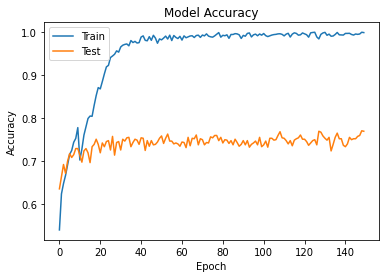

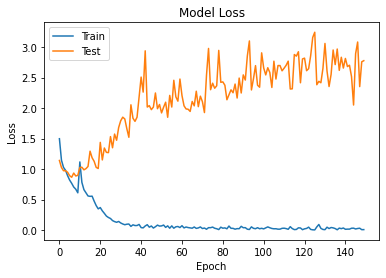

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [15]:
#save the tensorflow model
from tensorflow.keras.models import load_model
model=load_model('best_model_tf_model_bidirectional.h5')
performance_preds = model.predict(test_sequences)
print(performance_preds.shape)
decoded_preds = decode(label_encoder, performance_preds)
#print(decoded_preds)

(786, 13)


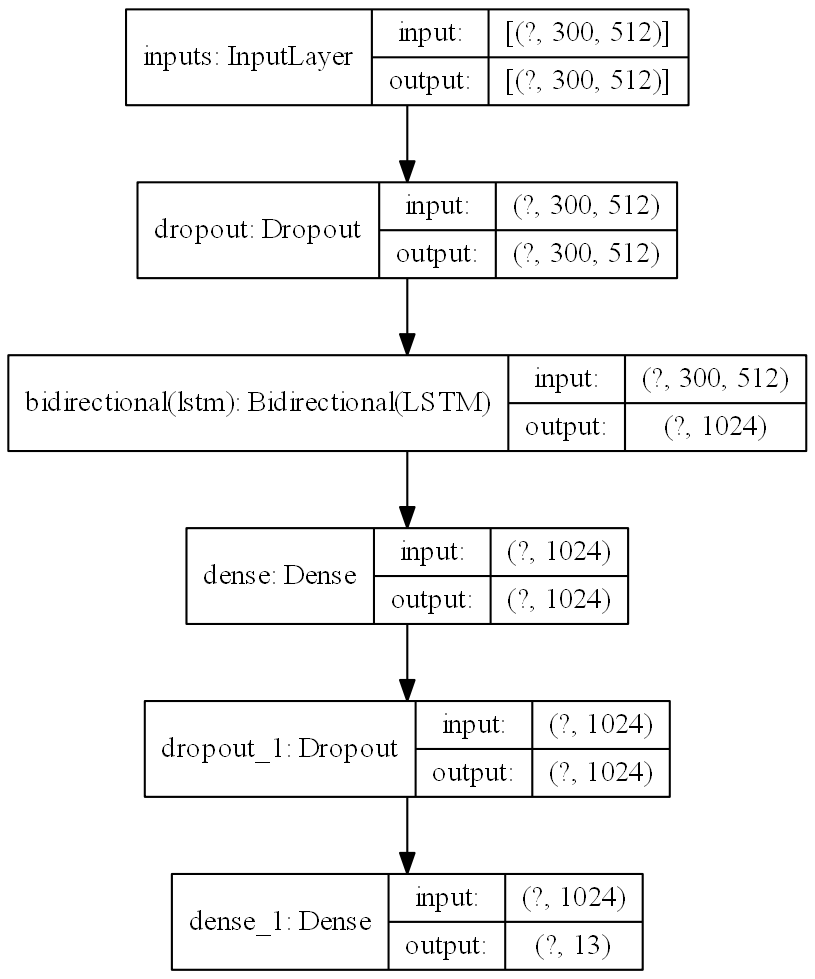

In [1]:
import pydot
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
model=load_model('best_model_tf_model_bidirectional.h5')
plot_model(model, to_file="rnn_model.png", show_shapes=True, show_layer_names=True, expand_nested=True, dpi=150)

In [16]:
from sklearn import svm
from sklearn.metrics import classification_report
cr = classification_report(test_labels, decoded_preds)
print(cr)

              precision    recall  f1-score   support

         1.0       0.84      0.92      0.88       402
         2.0       0.68      0.67      0.67        88
         3.0       0.76      0.84      0.80        68
         4.0       0.54      0.28      0.37        25
         5.0       0.50      0.20      0.29         5
         6.0       1.00      0.67      0.80         3
         7.0       0.57      1.00      0.73         4
         8.0       0.73      0.71      0.72        73
         9.0       0.69      0.43      0.53        67
        10.0       0.73      0.50      0.59        16
        11.0       1.00      0.75      0.86        12
        12.0       0.79      1.00      0.88        23

    accuracy                           0.79       786
   macro avg       0.74      0.66      0.68       786
weighted avg       0.78      0.79      0.78       786



[0.87619048 0.67428571 0.7972028  0.36842105 0.28571429 0.8
 0.72727273 0.72222222 0.53211009 0.59259259 0.85714286 0.88461538
 0.67648085 0.77634942]
[402  88  68  25   5   3   4  73  67  16  12  23 786 786]
0.7430598941765628


c:\users\u0155811\.conda\envs\tf-gpu\lib\site-packages\dc_stat_think\dc_stat_think.py:498: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_draw_bs_pairs" failed type inference due to: Invalid use of type(CPUDispatcher(<function _make_two_arg_numba_func.<locals>.f at 0x00000259EA0519D8>)) with parameters (array(float64, 1d, C), array(float64, 1d, C), Tuple())
 * parameterized
[1] During: resolving callee type: type(CPUDispatcher(<function _make_two_arg_numba_func.<locals>.f at 0x00000259EA0519D8>))
[2] During: typing of call at c:\users\u0155811\.conda\envs\tf-gpu\lib\site-packages\dc_stat_think\dc_stat_think.py (510)


File "..\..\users\u0155811\.conda\envs\tf-gpu\lib\site-packages\dc_stat_think\dc_stat_think.py", line 510:
    def _draw_bs_pairs(x, y):
        <source elided>
            bs_x, bs_y = x[bs_inds], y[bs_inds]
            bs_replicates[i] = f(bs_x, bs_y, args)
            ^

  @numba.jit
c:\users\u0155811\.conda\envs\t

[0.66324037 0.81618991]
0.741504387740228
0.0003927190314773198


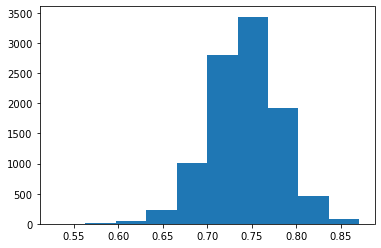

In [17]:
import ast
from scipy import stats
import dc_stat_think as dcst
import numpy as np
import matplotlib.pyplot as plt
# Add the label 13 which was missed in the splits
f1_score_list = []
support =[]
cr_dict = classification_report(test_labels, decoded_preds, output_dict=True)
for cr_value_dict in cr_dict.values():
    if isinstance(cr_value_dict, dict):
        f1_score_list.append(cr_value_dict['f1-score'])
        support.append(cr_value_dict['support'])
f1_score_np = np.array(f1_score_list)
support_np = np.array(support)
#Bootstrap sampling to calculate the confidence interval for f1-score
def weighted_average(x, y):
    return np.sum(x * y)/np.sum(y)

def boostrap_weighted_avg(data,size):
    return dcst.draw_bs_pairs(data, support, weighted_average, size=size)
   
print(f1_score_np)    
print(support_np)
print(weighted_average(f1_score_np, support_np))
bs_weighted_avg = boostrap_weighted_avg(f1_score_np, 10000)
print(np.percentile(bs_weighted_avg, [2.5, 97.5]))
print(np.mean(bs_weighted_avg))
print(stats.sem(bs_weighted_avg, axis=None, ddof=0))
plt.hist(bs_weighted_avg)
plt.show()

In [18]:
#epoch 100 f1-score 0.78 0.73 +- 0.0004
# Model: "model"
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #   
# =================================================================
# inputs (InputLayer)          [(None, 300, 512)]        0         
# _________________________________________________________________
# bidirectional (Bidirectional (None, 1024)              4198400   
# _________________________________________________________________
# dense (Dense)                (None, 1024)              1049600   
# _________________________________________________________________
# dropout (Dropout)            (None, 1024)              0         
# _________________________________________________________________
# dense_1 (Dense)              (None, 13)                13325     
# =================================================================
# Total params: 5,261,325
# Trainable params: 5,261,325
# Non-trainable params: 0
# _________________________________________________________________